Импорты

In [19]:
import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


Импорт данных с BQ

In [20]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [21]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [22]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

Испорт если у вас нет доступа к BQ

In [23]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


Подготовка данных

In [24]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [25]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [26]:
data.columns = ['ds', 'y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


<Axes: xlabel='ds'>

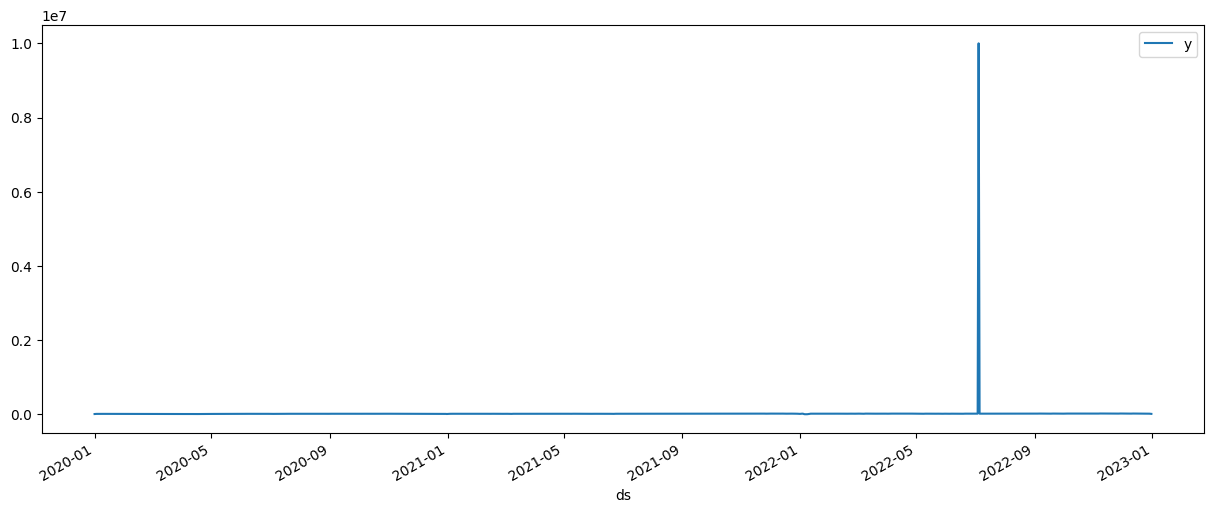

In [27]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [28]:
data.idxmax()

ds   2022-12-31
y    2022-07-05
dtype: datetime64[ns]

In [29]:
for i in range(2):
    data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_14928\1448882573.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


In [30]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

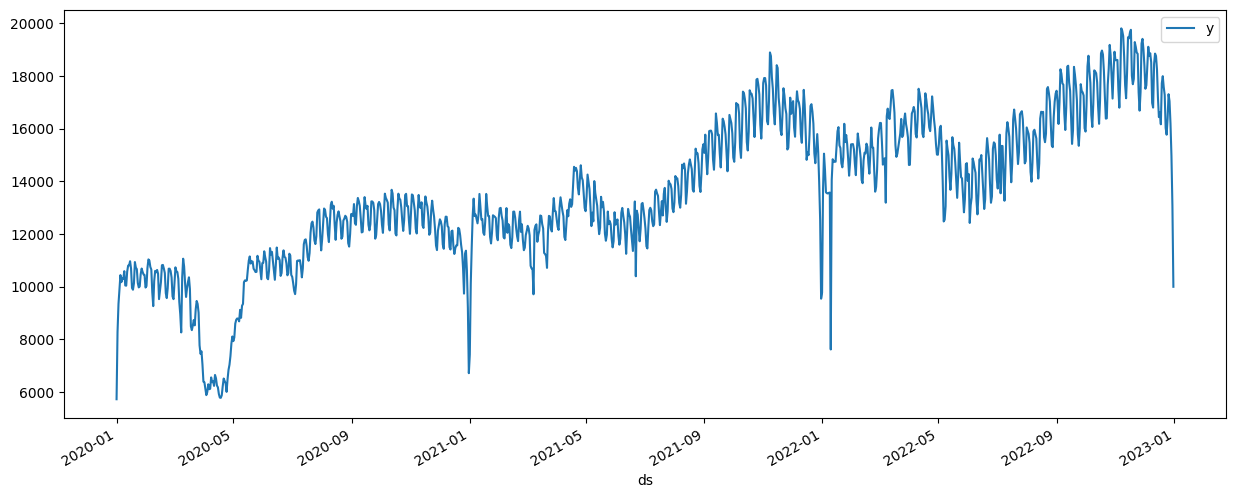

In [31]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [32]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03'))
            | (date >=pd.to_datetime('2023-03-23')) & (date <= pd.to_datetime('2023-04-23')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)

def is_covid(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-03-16')) & (date <= pd.to_datetime('2020-06-01')))

data['is_covid'] = data['ds'].apply(is_covid)
data['covid'] = data['is_covid'].apply(int)
data.head()
    

,ds,y,is_ramadan,ramadan,is_covid,covid
ds,,,,,,
2020-01-01,2020-01-01,5721.0,False,0,False,0
2020-01-02,2020-01-02,8274.0,False,0,False,0
2020-01-03,2020-01-03,9344.0,False,0,False,0
2020-01-04,2020-01-04,9864.0,False,0,False,0
2020-01-05,2020-01-05,10435.0,False,0,False,0


In [33]:
from Models import DecisionTree

# Ресемплирование данных по дням
daily_data = data.resample('D').mean()  # Можно использовать .sum(), .median(), или другие агрегирующие функции

# Создание объекта класса TreeReg
tree_reg_model = DecisionTree.TreeReg(max_depth=5, min_samples_split=2, max_leafs=20, bins=None)

# Обучение модели
tree_reg_model.fit(daily_data[['ds']], daily_data['y'])

# Предсказание
predictions = tree_reg_model.predict(daily_data[['ds']])


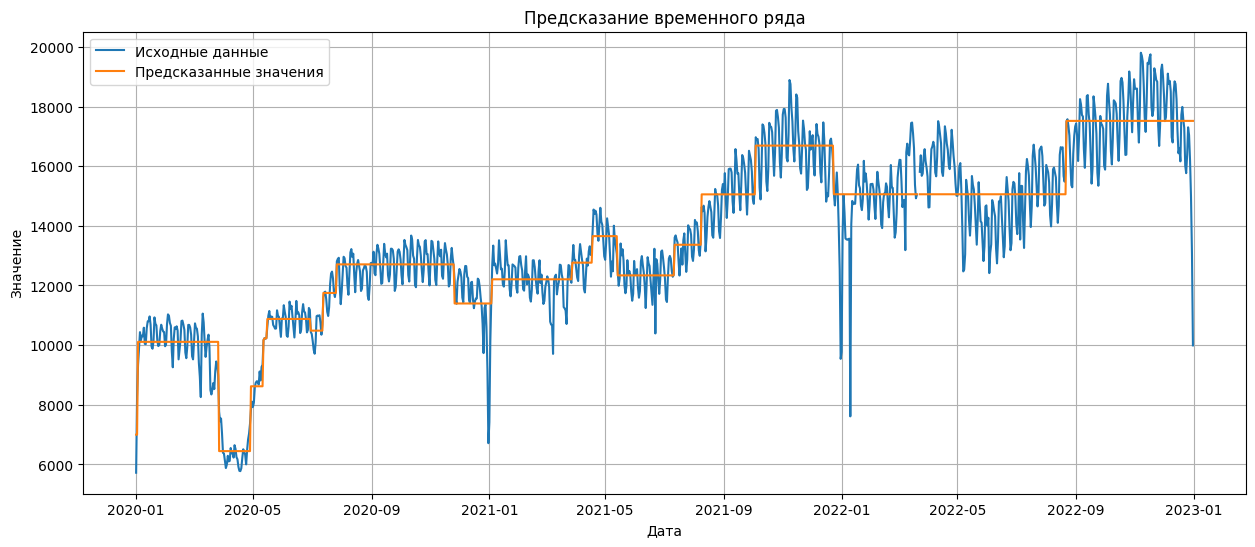

In [34]:
import matplotlib.pyplot as plt

# Создание графика
plt.figure(figsize=(15, 6))

# Визуализация исходных данных
plt.plot(daily_data['ds'], daily_data['y'], label='Исходные данные')

# Визуализация предсказанных значений
plt.plot(daily_data['ds'], predictions, label='Предсказанные значения')

# Настройка графика
plt.title('Предсказание временного ряда')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()


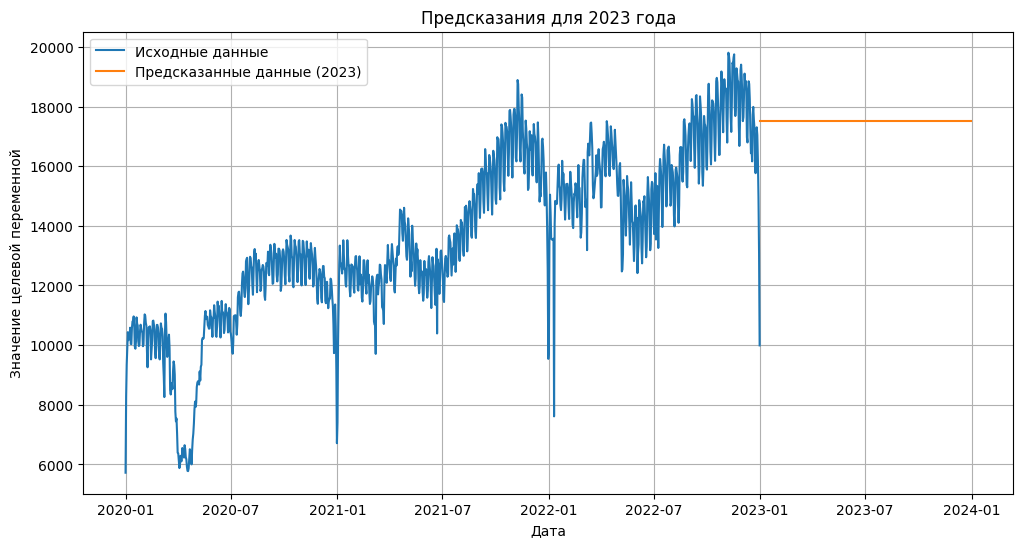

In [35]:
# Создание DataFrame с датами на 2023 год
dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
data_2023 = pd.DataFrame({'ds': dates_2023})

# Предсказание для 2023 года
predictions_2023 = tree_reg_model.predict(data_2023[['ds']])

# Создание графика
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'], label='Исходные данные')
plt.plot(data_2023['ds'], predictions_2023, label='Предсказанные данные (2023)')
plt.xlabel('Дата')
plt.ylabel('Значение целевой переменной')
plt.title('Предсказания для 2023 года')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# df_date = pd.DataFrame(dates_2023, columns=['ds'])
# df_pred = pd.DataFrame(predictions_2023, columns=['yhat_decision_tree'])

# df = pd.concat([df_date, df_pred], axis=1)


In [37]:
# # Сохраняем данные и предсказания в CSV-файл
# df.to_csv('decision_tree_predictions_2023.csv', index=False)